<a target="_blank" href="https://colab.research.google.com/github/MLGlobalHealth/StatML4PopHealth/blob/main/practicals/day1/practical1/1_stan_intro_lab_no_solution.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<center>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/imperial.png" width="250" vspace="8"/>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/mlgh.png" width="220" hspace="50" vspace="5"/>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/ammi.png" width="190"/>

<font size="6">Modern Statistics and Machine Learning
for Population Health in Africa </font>

<font size="4">24th - 28th March 2025</font>

</center>

# Computing lab: Stan Basics
## Modern Statistics and Machine Learning for Population Health in Africa
#### Tristan Naidoo and Sahoko Ishida
(With thanks to Yu Chen and Oliver Ratmann for the content)

## Study objectives

Hello all!

By the end of this lab,

- you will understand the key benefits of modern statistical computing languages such as `Stan`; and
- you will have installed the `Stan` software within `Python`, via `cmdstan`; and
- you will be familiar with a typical analysis workflow using `Stan`, and associated `Python` commands.

## Why Stan?

`Stan`

- is an open-source statistical inference software, which implements gradient-based MCMC to sample from posterior distributions.
- allows us to focus on statistical modelling, rather than implementing inference algorithms.
- algorithms are implemented in \textsl{C++}, and can be accessed through interfaces like `CmdStanPy` and `PyStan` in `Python`.
- Bayesian models are written in text files.

There are several modern alternatives to `Stan`, including

- [numpyro](https://num.pyro.ai/en/latest/index.html#introductory-tutorials); and
- [TMD](https://github.com/kaskr/adcomp/wiki); and
- [Nimble](https://r-nimble.org).

## Installation
For this course we will use `CmdStanPy`, which is a recently developed lightweight alternative to `PyStan` for interfacing with Stan in Python. The functions to compile, run, and access the output of Bayesian inference algorithms are very similar, but not identical to those in the `PyStan` package. However, both `CmdStanPy` and `PyStan` read exactly the same `Stan` model files, and so `CmdStanPy` is an excellent alternative if you run into installation issues with `PyStan`, or if you would rather work with the most recent `Python` interface to `Stan`'s algorithms.

Throughout this course, we will work in Google Colab. The steps to install `CmdStanPy` and `CmdStan` in your Colab instance are provided below.

If you would like to install `CmdStanPy` and `CmdStan` on your local machine please follow the instructions provided [here](https://mc-stan.org/cmdstanpy/installation.html).

#### Step 1: Install the python package `CmdStanPy`

In [1]:
!pip install --upgrade cmdstanpy==1.2.5

#### Step 2: Install `CmdStan`

We install the pre-built colab CmdStan binary because its faster than compiling from source via `install_cmdstan()` function. If you are installing locally please download the appropriate binary or alternatively use `install_cmdstan()`.

In [2]:
import os
import shutil
import urllib

In [3]:
tgz_file = 'colab-cmdstan-2.36.0.tar.gz'
tgz_url = 'https://github.com/stan-dev/cmdstan/releases/download/v2.36.0/colab-cmdstan-2.36.0.tgz'
if not os.path.exists(tgz_file):
    urllib.request.urlretrieve(tgz_url, tgz_file)
    shutil.unpack_archive(tgz_file)

We also need to install an additional linux dependency that is missing on the machine that our colab instance is running on.

In [4]:
!apt install libtbb2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libtbb2
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 101 kB of archives.
After this operation, 313 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libtbb2 amd64 2020.3-1ubuntu3 [101 kB]
Fetched 101 kB in 0s (318 kB/s)
Selecting previously unselected package libtbb2:amd64.
(Reading database ... 126209 files and directories currently installed.)
Preparing to unpack .../libtbb2_2020.3-1ubuntu3_amd64.deb ...
Unpacking libtbb2:amd64 (2020.3-1ubuntu3) ...
Setting up libtbb2:amd64 (2020.3-1ubuntu3) ...
Processing triggers for libc-bin (2.35-0ubuntu3.8) ...
/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm_debug.so.1 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm.so.1 is not a symbol

#### Step 3: Specify `CmdStan` path
We set the `CmdStan` path using an environment variable. This tells your machine where to look for `CmdStan`.

In [5]:
os.environ['CMDSTAN'] = './cmdstan-2.36.0'

Next, we check `CmdStan` path. This should be the same as what is specified above.

In [6]:
from cmdstanpy import CmdStanModel, cmdstan_path
cmdstan_path()

'cmdstan-2.36.0'

## Hello world example, using `CmdStanPy`

Let us start with a very simple example to become familiar with `Stan`.

We aim to fit a normal model to 100 data points $y_i, i=1,\dotsc,n=100$, and estimate the joint posterior distribution of the mean and standard deviation numerically with Stan,

\begin{align*}
&y_{i} \sim \text{Normal}(\mu, \sigma^2) \\
& \mu \sim \text{Normal}(0,100)\\
& \sigma\sim \text{Half-Cauchy}(0,1).
\end{align*}

Let us compile the corresponding `Stan` model and run two Hamiltonian Monte Carlo (HMC) chains for 4,000 iterations each, including 1,000 warmup iterations.

Every `Stan` model files is structured in terms of the following blocks:

- `data` block: specifies data required to fit the model
- `transformed data` block: specifies temporary transformations of the data, e.g. QR decomposition of $X$; variables that do not change
- `parameters` block: specifies all parameters that are fitted; cannot be assigned values directly
- `transformed parameters` block: optional transformations of parameters, e.g. risk differences
- `model` block: specifies the model in terms of likelihood and priors
- `generated quantities` block: quantities that depend on parameters and data, and do not affect inference

Here is a simple implementation of our Hello World normal model:

In [7]:
# Hello World normal model
model1_text = """
data{
    int<lower=1> N;
    array [N] real y;
}
parameters{
    real mu;
    real<lower=0> sigma;
}
model{
    sigma ~ cauchy( 0 , 1 );
    mu ~ normal( 0 , 10 );
    y ~ normal( mu , sigma );
}
"""

To use this model in `Python`, we start by loading up our `Python` packages.
If you are running this notebook on Google colab the packages we need are included by default. If you are running this notebook locally please install any missing packages.

In [8]:
import os
import pickle
from pathlib import Path

import arviz as az
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")

import logging

logging.getLogger("cmdstanpy").setLevel(logging.INFO)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Adjust this as required - this is where your output will be stored.
output_dir = Path(*["drive", "MyDrive", "StatML4PopHealth", "output"])
output_dir.mkdir(parents=True, exist_ok=True)

Now, please complete the following code block to sample from the joint posterior associated with the Hello World model for 4,000 iterations including 1,000 iterations of warmup. Setup two Hamiltonian Monte Carlo chains and initialise the two chains at $(\mu=1, \sigma=2)$ and $(\mu=-1, \sigma=0.5)$:


In [12]:
# Set seed for reproducibility
np.random.seed(10680)  # Use your birth date

# Generate random normal data
y = np.random.normal(loc=0, scale=1, size=100)

# Create data dictionary for Stan
stan_data = {
    'N': len(y),
    'y': y
}

# Write the Stan model to a file
# CmdStanPy requires the model to be written to a file
model1_filename = output_dir.joinpath("helloworld.stan")
with open(model1_filename, "w") as f:
    f.write(model1_text)

In [13]:
# Compile the Stan model using CmdStanPy
model1_compiled = CmdStanModel(stan_file=model1_filename)

12:37:37 - cmdstanpy - INFO - compiling stan file /content/drive/MyDrive/StatML4PopHealth/output/helloworld.stan to exe file /content/drive/MyDrive/StatML4PopHealth/output/helloworld
INFO:cmdstanpy:compiling stan file /content/drive/MyDrive/StatML4PopHealth/output/helloworld.stan to exe file /content/drive/MyDrive/StatML4PopHealth/output/helloworld
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=helloworld.stan /content/drive/MyDrive/StatML4PopHealth/output/helloworld
cwd: cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Compiling pre-compiled header. This might take a few seconds. ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/

In [14]:
# Sample from the joint posterior of the Hello World model using CmdStanPy
model1_fit = model1_compiled.sample(
    data=stan_data,
    seed=123,
    chains=2,
    parallel_chains=2,
    iter_warmup=1000,
    iter_sampling=4000,
    refresh=500,  # Print update every 500 iterations
    save_warmup=True,
    inits=[{'mu': 1, 'sigma': 2},
           {'mu': -1, 'sigma': 0.5}]  # Initial values for the chains
)

# -- You don't need to do this in the TODO chunks below, it's just an example
# in case you want to save your output object
# Save the output to a pickle file
output_fit_file = output_dir.joinpath("model1_fit_cmdstanpy.pkl")
with open(output_fit_file, "wb") as f:
    pickle.dump(model1_fit, f)

DEBUG:cmdstanpy:cmd: /content/drive/MyDrive/StatML4PopHealth/output/helloworld info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd4g0v_ws/pvmdn5do.json
12:38:38 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/StatML4PopHealth/output/helloworld', 'id=1', 'random', 'seed=123', 'data', 'file=/tmp/tmpd4g0v_ws/pvmdn5do.json', 'init=/tmp/tmpd4g0v_ws/xadzyrav_1.json', 'output', 'file=/tmp/tmpd4g0v_ws/helloworld5yh0okyw/helloworld-20250324123838_1.csv', 'refresh=500', 'method=sample', 'num_samples=4000', 'num_warmup=1000', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/StatML4PopHealth/output/helloworld', 'id=2', 'random', 'seed=123', 'data', 'file=/tmp/tmpd4g0v_ws/pvmdn5do.json', 'init=/tmp/tmpd4g0v_ws/xadzyrav_2.json', 'output', 'file=/tmp/tmpd4g0v_ws/helloworld5yh0okyw/helloworld-20250324123838_2.csv', 'refresh=500', 'method=sample', 'num_samples=4000', 'num_warmup=1000', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1']


12:38:38 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=2, chain_ids=[1, 2], num_processes=2
 cmd (chain 1):
	['/content/drive/MyDrive/StatML4PopHealth/output/helloworld', 'id=1', 'random', 'seed=123', 'data', 'file=/tmp/tmpd4g0v_ws/pvmdn5do.json', 'init=/tmp/tmpd4g0v_ws/xadzyrav_1.json', 'output', 'file=/tmp/tmpd4g0v_ws/helloworld5yh0okyw/helloworld-20250324123838_1.csv', 'refresh=500', 'method=sample', 'num_samples=4000', 'num_warmup=1000', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpd4g0v_ws/helloworld5yh0okyw/helloworld-20250324123838_1.csv
 console_msgs (if any):
	/tmp/tmpd4g0v_ws/helloworld5yh0okyw/helloworld-20250324123838_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 4000
    num_warmup = 1000 (Default)
    save_warmup = true
    thin = 1 (Default)
    ad

Next, we explore the following code snippets that provide key functions to assess the Monte Carlo output.

In [15]:
# -- You don't need to do this in the TODO chunks below, it's just an example
# in case you want to save your output object
# Load the output from the pickle file saved earlier
with open(output_fit_file, "rb") as f:
    model1_fit = pickle.load(f)

# Specify the parameters you want to check
model1_pars = ["mu", "sigma"]
model1_pars_with_lp = model1_pars + ["lp__"]

# Get summary of the specified parameters
model1_summary = model1_fit.summary(sig_figs=4)
model1_summary.loc[model1_pars_with_lp]

DEBUG:cmdstanpy:cmd: cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=4 --csv_filename=/tmp/tmpd4g0v_ws/stansummary-helloworld-plwiy4ej.csv /tmp/tmpd4g0v_ws/helloworld5yh0okyw/helloworld-20250324123838_1.csv /tmp/tmpd4g0v_ws/helloworld5yh0okyw/helloworld-20250324123838_2.csv
cwd: None


,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
mu,-0.004917,0.001119,0.09150,0.09278,-0.1541,-0.005205,0.1452,6717.0,4670.0,1.0000
sigma,0.915500,0.000768,0.06441,0.06313,0.8178,0.911300,1.0260,7181.0,5247.0,1.0000
lp__,-41.600000,0.016230,0.98890,0.68440,-43.5300,-41.300000,-40.6700,3893.0,4861.0,0.9999


In [16]:
# We can also use a library to get this summary
# Convert the CmdStanPy model fit to ArviZ InferenceData
model1_fit_az_idata = az.from_cmdstanpy(model1_fit, save_warmup=True)

# arviz parses our data into groups based on our fit object
model1_fit_az_idata

Inference data with groups:
	> posterior
	> sample_stats

Warmup iterations saved (warmup_*).

In [17]:
# Get summary statistics, including 2.75% and 97.5% quantiles
summary_stats = az.summary(model1_fit_az_idata,
                           var_names=model1_pars,
                           group="posterior",
                           hdi_prob=0.95,
                           kind="all"# 95% highest density interval
                           )

summary_stats

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.005,0.091,-0.182,0.172,0.001,0.001,6717.0,4670.0,1.0
sigma,0.916,0.064,0.796,1.045,0.001,0.001,7181.0,5247.0,1.0


In [18]:
# To plot traces and assess convergence, extract
# Monte Carlo samples including warmup in default
# array format that keeps all chains separate

# It's often helpful to plot the log posterior density too. Since it is a
# sample stat and arviz can only access one group at a time, we will manually
# add it to make it easier to view everything together
model1_fit_az_idata["posterior"]["lp"] = model1_fit_az_idata["sample_stats"]["lp"]
model1_pars_with_lp = model1_pars + ["lp"]

# Print summary of the parameters
summary_stats = az.summary(model1_fit_az_idata,
                           var_names=model1_pars_with_lp,
                           group="posterior",
                           hdi_prob=0.95,
                           kind="all"
                          )

summary_stats

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.005,0.091,-0.182,0.172,0.001,0.001,6717.0,4670.0,1.0
sigma,0.916,0.064,0.796,1.045,0.001,0.001,7181.0,5247.0,1.0
lp,-41.603,0.989,-43.531,-40.618,0.016,0.025,3893.0,4861.0,1.0


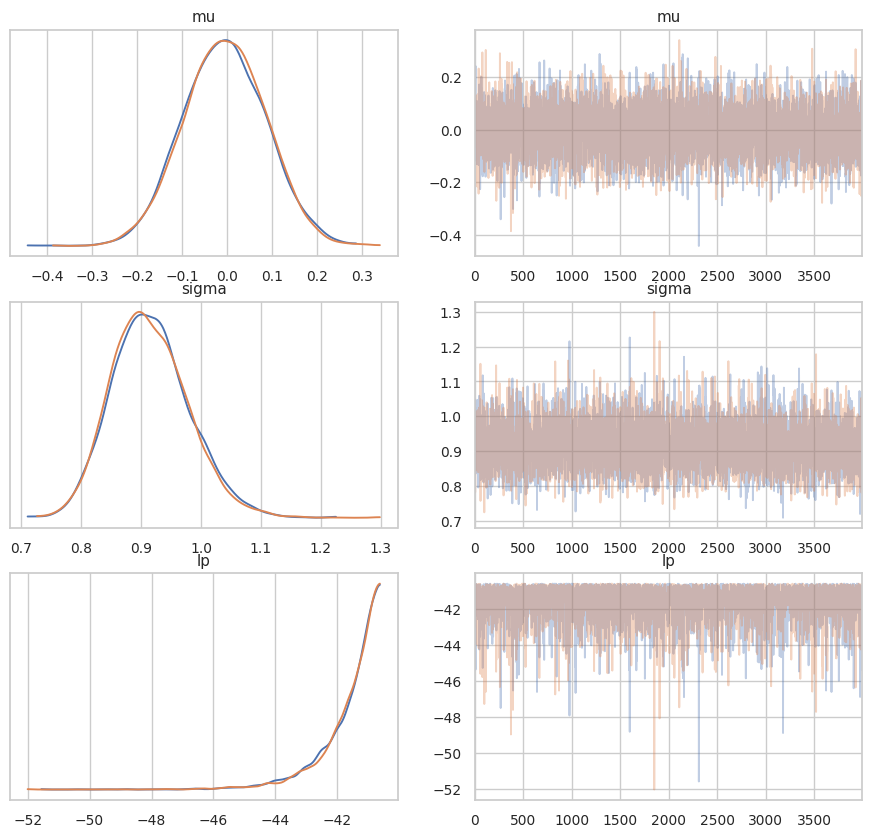

In [19]:
# Plot trace for parameters (mu, sigma, and lp)
# different colours are different chains
az.plot_trace(model1_fit_az_idata,
              filter_vars="like",
              var_names=model1_pars_with_lp,
              combined=False,
              compact=False,
              kind="trace",
              figsize=(11, 10))

plt.show()

# Save the plot to a PDF file
plt.savefig(output_dir.joinpath("model1_cmdstanpy_trace_arviz.pdf"),
            format="pdf",
            bbox_inches="tight")

plt.close()

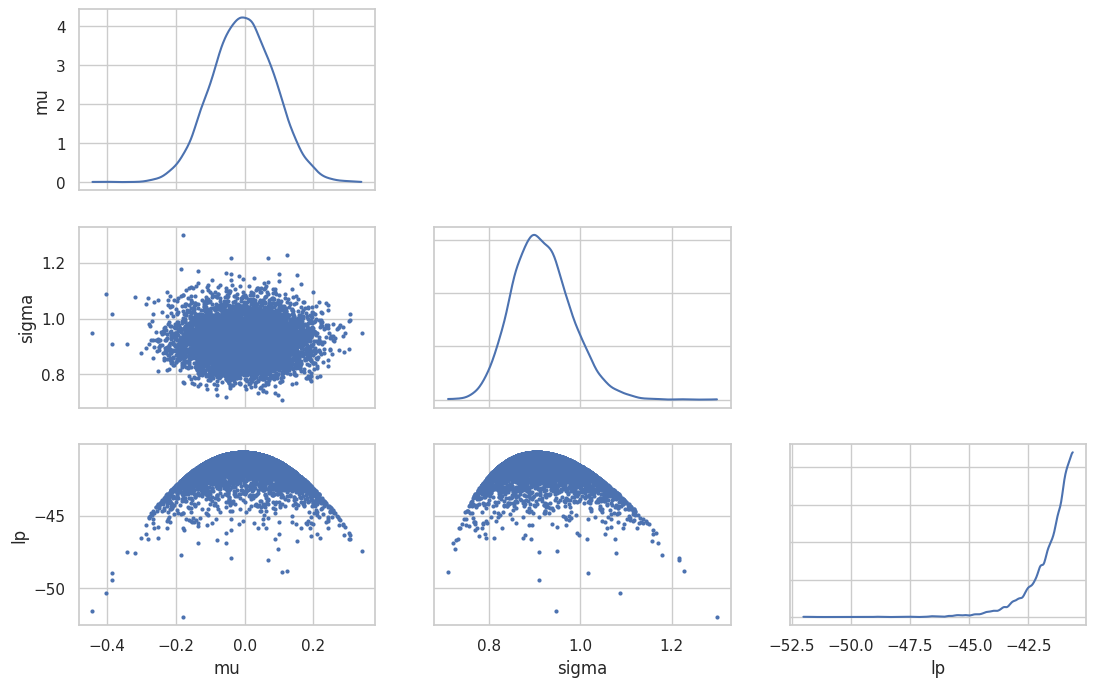

In [20]:
# Extract the posterior samples excluding warmup
# Make the pairs plot (including log-posterior)
az.plot_pair(model1_fit_az_idata,
             var_names=model1_pars_with_lp,
             marginals=True,
             figsize=(13, 8))

plt.show()

plt.savefig(output_dir.joinpath("model1_cmdstanpy_pairsplot.pdf"),
            format="pdf", bbox_inches="tight")
plt.close()

In [21]:
# To manipulate the posterior Monte Carlo samples after warmup we
# typically prefer to extract the samples as a DataFrame (excluding warmup)
posterior_df = model1_fit_az_idata.posterior.to_dataframe()
posterior_df.head()

mu     sigma       lp
chain draw                             
0     0     0.009446  0.833402 -41.3441
      1    -0.118145  0.837971 -42.1508
      2     0.160777  0.938919 -42.3080
      3     0.170287  0.950737 -42.5535
      4     0.232976  0.966181 -44.0626

## The flat priors example

Let us adapt the Hello World example a wee bit, so that we can explore how a non-successful numerical inference run with `Stan` might look like.

We will engineer a statistical problem that is very hard to sample from, due to unsuitable prior specifications. First, we will reduce the data to just two data points. Second, we will specify unbounded uniform priors are specified for both $\mu$ and $\sigma$, which says that prior values close to infinity are as likely as close to zero.

The learning outcome here is that a common reason why `Stan` fails to sample from a joint posterior is that the priors are misspecified as either way too wide, or way too narrow.

In [22]:
# Data now consist of TWO data points ONLY
y = np.array([-1, 1])
stan_data = {
    'N': len(y),
    'y': y
}

In [23]:
# Define the Stan model with flat priors on mu and sigma
model2_text = """
data {
    int<lower=1> N;
    array [N] real y;
}
parameters {
    real mu;
    real<lower=0> sigma;
}
model {
    y ~ normal(mu, sigma);
}
"""

Now, let us compile the `Stan` model file, and run `Stan`'s Hamiltonian Monte Carlo algorithm for $1000$ iterations that include $400$ warmup iterations. Setup two Hamiltonian Monte Carlo chains and initialise both chains at $(\mu=0, \sigma=1)$. Then make a trace plot:

In [24]:
# Write the Stan model to a file
model2_filename = "model2.stan"
with open(model2_filename, 'w') as f:
    f.write(model2_text)

# Compile the Stan model using CmdStanPy
model2_compiled = CmdStanModel(stan_file=model2_filename)

# Sample from the posterior distribution
model2_fit = model2_compiled.sample(
    data=stan_data,
    seed=123,
    chains=2,
    parallel_chains=2,
    iter_sampling=1400,
    iter_warmup=400,
    refresh=500,
    save_warmup=True,
    inits=[{'mu': 0, 'sigma': 1},
          {'mu': 0, 'sigma': 1}]
    )

12:42:18 - cmdstanpy - INFO - compiling stan file /content/model2.stan to exe file /content/model2
INFO:cmdstanpy:compiling stan file /content/model2.stan to exe file /content/model2
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=model2.stan /content/model2
cwd: cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=model2.stan --o=/content/model2.hpp /content/model2.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /content/model2.o /co

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/model2', 'id=1', 'random', 'seed=123', 'data', 'file=/tmp/tmpd4g0v_ws/igy52mqo.json', 'init=/tmp/tmpd4g0v_ws/dy3uhx8t_1.json', 'output', 'file=/tmp/tmpd4g0v_ws/model2kjwq_ka_/model2-20250324124231_1.csv', 'refresh=500', 'method=sample', 'num_samples=1400', 'num_warmup=400', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/model2', 'id=2', 'random', 'seed=123', 'data', 'file=/tmp/tmpd4g0v_ws/igy52mqo.json', 'init=/tmp/tmpd4g0v_ws/dy3uhx8t_2.json', 'output', 'file=/tmp/tmpd4g0v_ws/model2kjwq_ka_/model2-20250324124231_2.csv', 'refresh=500', 'method=sample', 'num_samples=1400', 'num_warmup=400', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1']


12:42:31 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=2, chain_ids=[1, 2], num_processes=2
 cmd (chain 1):
	['/content/model2', 'id=1', 'random', 'seed=123', 'data', 'file=/tmp/tmpd4g0v_ws/igy52mqo.json', 'init=/tmp/tmpd4g0v_ws/dy3uhx8t_1.json', 'output', 'file=/tmp/tmpd4g0v_ws/model2kjwq_ka_/model2-20250324124231_1.csv', 'refresh=500', 'method=sample', 'num_samples=1400', 'num_warmup=400', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpd4g0v_ws/model2kjwq_ka_/model2-20250324124231_1.csv
 console_msgs (if any):
	/tmp/tmpd4g0v_ws/model2kjwq_ka_/model2-20250324124231_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1400
    num_warmup = 400
    save_warmup = true
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
      delta = 

In [25]:
# Create an ArviZ InferenceData object
model2_fit_az_idata = az.from_cmdstanpy(model2_fit, save_warmup=True)

# Print the summary of the sampling results
model2_pars = ["mu", "sigma"]

summary_stats = az.summary(model2_fit_az_idata,
                           var_names=model2_pars,
                           group="posterior",
                           hdi_prob=0.95,
                           kind="all")

summary_stats

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,175792.016,3.187130e+06,-9929820.000,6452830.0,819151.580,8.025640e+05,14.0,36.0,1.29
sigma,8528434.392,7.382861e+07,8.539,24390000.0,3010969.059,2.014396e+07,5.0,29.0,1.40


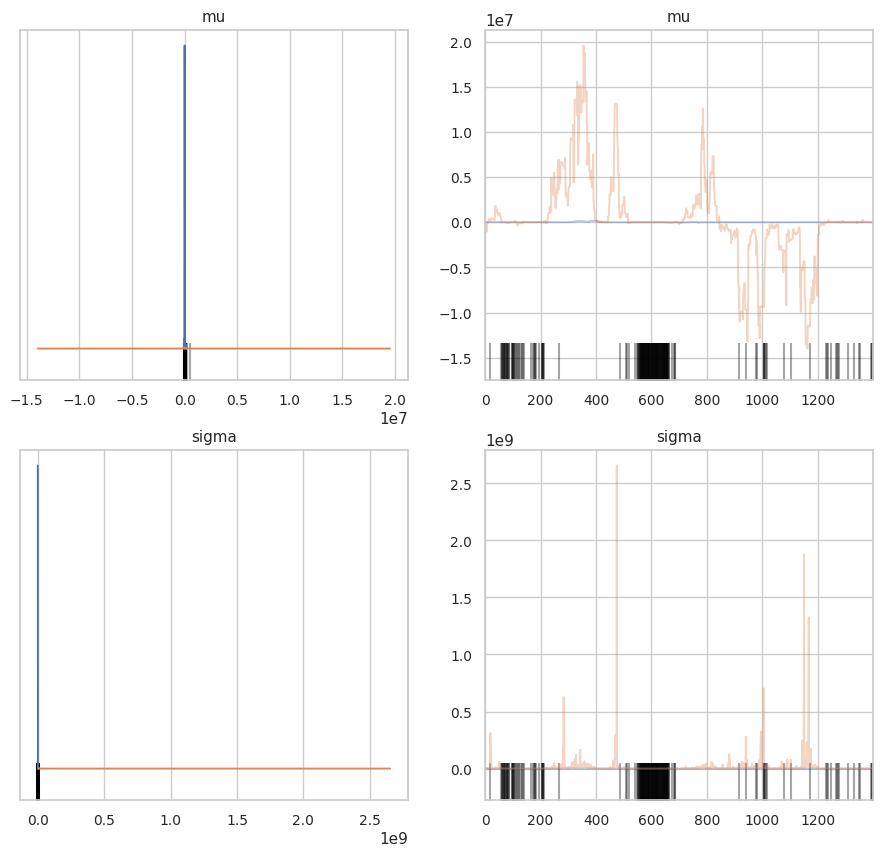

In [26]:
# Trace plots
az.plot_trace(model2_fit_az_idata,
              filter_vars="like",
              var_names=["mu", "sigma"],
              combined=False,
              compact=False,
              kind="trace",
              figsize=(11, 10))

plt.show()

# Save the plot to a PDF file
plt.savefig(output_dir.joinpath("model2_cmdstanpy_trace_arviz.pdf"),
            format="pdf",
            bbox_inches="tight")

plt.close()

For comparison, let us now place weakly informative priors on $\mu$ and $\sigma$, and repeat the excercise:

In [27]:
# Specify Stan model with weakly informative prior on mu and sigma
model3_text = """
data{
    int<lower=1> N;
    array [N] real y;
}
parameters{
    real mu;
    real<lower=0> sigma;
}
model{
    sigma ~ cauchy( 0 , 1 );
    mu ~ normal( 0 , 10 );
    y ~ normal( mu , sigma );
}
"""

In [28]:
# TODO: Write the Stan model to a file
model3_filename = output_dir.joinpath("some_priors.stan")
with open(model3_filename, "w") as f:
    f.write(model3_text)

# TODO: Compile the Stan model using CmdStanPy
model3_compiled = CmdStanModel(stan_file=model3_filename)


# TODO: Sample from the posterior distribution
model3_fit = model3_compiled.sample(
    data=stan_data,
    seed=123,
    chains=2,
    parallel_chains=2,
    iter_sampling=1400,
    iter_warmup=400,
    refresh=500,
    save_warmup=True,
    inits=[{'mu': 0, 'sigma': 1},
          {'mu': 0, 'sigma': 1}]
    )

12:49:25 - cmdstanpy - INFO - compiling stan file /content/drive/MyDrive/StatML4PopHealth/output/some_priors.stan to exe file /content/drive/MyDrive/StatML4PopHealth/output/some_priors
INFO:cmdstanpy:compiling stan file /content/drive/MyDrive/StatML4PopHealth/output/some_priors.stan to exe file /content/drive/MyDrive/StatML4PopHealth/output/some_priors
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=some_priors.stan /content/drive/MyDrive/StatML4PopHealth/output/some_priors
cwd: cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=some_priors.stan --o=/content/drive/MyDrive/StatML4PopHealth/output/some_priors.hpp /content/drive/MyDrive/StatML4PopHealth/output/some_priors.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/C

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/StatML4PopHealth/output/some_priors', 'id=1', 'random', 'seed=123', 'data', 'file=/tmp/tmpd4g0v_ws/1_2nt69n.json', 'init=/tmp/tmpd4g0v_ws/7q44gai__1.json', 'output', 'file=/tmp/tmpd4g0v_ws/some_priorsqllers2f/some_priors-20250324124941_1.csv', 'refresh=500', 'method=sample', 'num_samples=1400', 'num_warmup=400', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/StatML4PopHealth/output/some_priors', 'id=2', 'random', 'seed=123', 'data', 'file=/tmp/tmpd4g0v_ws/1_2nt69n.json', 'init=/tmp/tmpd4g0v_ws/7q44gai__2.json', 'output', 'file=/tmp/tmpd4g0v_ws/some_priorsqllers2f/some_priors-20250324124941_2.csv', 'refresh=500', 'method=sample', 'num_samples=1400', 'num_warmup=400', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1']


12:49:42 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=2, chain_ids=[1, 2], num_processes=2
 cmd (chain 1):
	['/content/drive/MyDrive/StatML4PopHealth/output/some_priors', 'id=1', 'random', 'seed=123', 'data', 'file=/tmp/tmpd4g0v_ws/1_2nt69n.json', 'init=/tmp/tmpd4g0v_ws/7q44gai__1.json', 'output', 'file=/tmp/tmpd4g0v_ws/some_priorsqllers2f/some_priors-20250324124941_1.csv', 'refresh=500', 'method=sample', 'num_samples=1400', 'num_warmup=400', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpd4g0v_ws/some_priorsqllers2f/some_priors-20250324124941_1.csv
 console_msgs (if any):
	/tmp/tmpd4g0v_ws/some_priorsqllers2f/some_priors-20250324124941_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1400
    num_warmup = 400
    save_warmup = true
    thin = 1 (Default)
    adapt
 

In [ ]:
# TODO: Create an ArviZ InferenceData object
model3_fit_az_idata = az.from_cmdstanpy(model3_fit, save_warmup=True)

# TODO: Print the summary of the sampling results

In [ ]:
# TODO: Trace plots

# TODO: Save the plot to a PDF file

## The unidentifiable parameters example

Finally, we will adapt the Hello World example slightly differently, again to explore how a non-successful numerical inference run with `Stan` might look like in the case when two parameters cannot be estimated from the data, only their combination. To engineer this situation, we will introduce two unknown random variables $\alpha_1$ and $\alpha_2$, and say that the sum of both is the mean in our Hello World normal model.

The learning outcome here is that a common reason why `Stan` fails to sample from a joint posterior is that the parameters in a model are highly correlated, and there are multiple equally likely solutions under the model as specified.

Let us start with unbounded uniform priors specified on $\alpha_1$ and $\alpha_2$.

In [ ]:
# specify Stan model with unidentifiable parameters and flat prior
model4_text = """
data{
    int<lower=1> N;
    array [N] real y;
}
parameters{
    real alpha1;
    real alpha2;
    real<lower=0> sigma;
}
transformed parameters{
    real mu= alpha1 + alpha2;
}
model{
    sigma ~ cauchy( 0 , 1 );
    y ~ normal( mu , sigma );
}
"""

Let us run `Stan`'s Hamiltonian Monte Carlo algorithm for $1000$ iterations that include $400$ warmup iterations. Setup two Hamiltonian Monte Carlo chains and initialise both chains at $(\mu=0, \sigma=1)$. Then make a trace plot:

In [ ]:
# TODO: Write the Stan model to a file

# TODO: Compile the Stan model using CmdStanPy

# TODO: Sample from the posterior distribution

In [ ]:
# TODO: Create an ArviZ InferenceData object

# TODO: Print the summary of the sampling results

In [ ]:
# TODO: Trace plots

# TODO: Save the plot to a PDF file

In [ ]:
# TODO: Plot pairs

# TODO: Save the plot to a PDF file

For comparison, let us now consider a model with weakly informative $\text{Normal}(0,10^2)$ priors on $\alpha_1$ and $\alpha_2$. Again, let us run `Stan`'s Hamiltonian Monte Carlo algorithm for $1000$ iterations that include $400$ warmup iterations. Setup two Hamiltonian Monte Carlo chains and initialise both chains at $(\alpha_1=0, \alpha_2=0, \sigma=1)$. Then make a trace plot, and also a pair plot as shown above:

In [ ]:
# specify Stan model with unidentifiable parameters and flat prior
model5_text = """
data{
    int<lower=1> N;
    array [N] real y;
}
parameters{
    real alpha1;
    real alpha2;
    real<lower=0> sigma;
}
transformed parameters{
    real mu= alpha1 + alpha2;
}
model{
    sigma ~ cauchy( 0 , 1 );
    alpha1 ~ normal(0, 10);
    alpha2 ~ normal(0, 10);
    y ~ normal( mu , sigma );
}
"""

In [ ]:
# TODO: Write the Stan model to a file

# TODO: Compile the Stan model using CmdStanPy

# TODO: Sample from the posterior distribution

In [ ]:
# TODO: Create an ArviZ InferenceData object

# TODO: Print the summary of the sampling results

In [ ]:
# TODO: Trace plots

# TODO: Save the plot to a PDF file

In [ ]:
# TODO: Plot pairs

# TODO: Save the plot to a PDF file

Let us reflect on the trace plots and the pair plots for the different models:

- What do you observe in terms of convergence, mixing, and the HMC traces in general?
- What does the pair plot reveal to you?

The first observation is that provided that the prior distributions on model parameters are suitably specified through e.g. weakly informative priors, then Stan's Hamiltonian Monte Carlo algorithm usually works very well to provide us with Monte Carlo samples from the joint posterior distribution.

The second observation is related to the pairs plot. We can see that several parameters are extremely highly correlated. In fact, the posterior alpha1 is essentially equal to -alpha2. This means that the joint posterior distribution is essentially concentrated on a hyperplane, a set of measure zero. Yet, Stan's algorithm understands the geometry of the posterior distribution, and can efficiently sample from it. This would be very difficult with a standard Metropolis Hastings algorithm.

## Hello world example using `pystan`

Finally, we revisit our Hello World example to see how exactly each step above can be implemented with `pystan`:

In [ ]:
!pip install pystan nest-asyncio

Running in `pystan` in a notebook is problematic since Jupyter blocks certain asyncio functions. To address this problem, we use `nest-asyncio`.

See this [`pystan` FAQ](https://pystan.readthedocs.io/en/latest/faq.html) for more information.

In [ ]:
import stan
import nest_asyncio

nest_asyncio.apply()

In [ ]:
# Make data
np.random.seed(10680)  # Use your birth date
y = np.random.normal(0, 1, 100)  # Generate random data

stan_data = {
    'N': len(y),
    'y': y
}

In [ ]:
# Stan model code (using the same 'model1.stan' as in your R code)
pystan_model1_text = """
data{
    int<lower=1> N;
    array[N] real y;
}
parameters{
    real mu;
    real<lower=0> sigma;
}
model{
    sigma ~ cauchy( 0 , 1 );
    mu ~ normal( 0 , 10 );
    y ~ normal( mu , sigma );
}
"""

In [ ]:
# Compile the model - note we do not need to save the text
model = stan.build(pystan_model1_text, data=stan_data, random_seed=123)

In [ ]:
# Fit the model
model1_pystan_fit = model.sample(num_chains=2,
                                 num_samples=4000,
                                 num_warmup=1000,
                                 save_warmup=True,
                                 init=[{'mu': 1, 'sigma': 2},
                                       {'mu': -1, 'sigma': 0.5}])

# Save the output to a file
with open("model1_pystan_fit.pkl", "wb") as f:
    pickle.dump(model1_pystan_fit, f)

In [ ]:
# Print the summary of the sampling results
model1_pystan_fit_az_idata = az.from_pystan(model1_pystan_fit, save_warmup=True)

model1_pystan_fit_az_idata

# Get summary statistics, including 2.75% and 97.5% quantiles
summary_stats = az.summary(model1_pystan_fit_az_idata,
                           var_names=["mu", "sigma"],
                           group="posterior",
                           hdi_prob=0.95,
                           kind="all"# 95% highest density interval
                           )

summary_stats

In [ ]:
# To plot traces and assess convergence, extract
# Monte Carlo samples including warmup in default
# array format that keeps all chains separate

# It's often helpful to plot the log posterior density too. Since it is a
# sample stat and arviz can only access one group at a time, we will manually
# add it to make it easier to view everything together
model1_pystan_fit_az_idata["posterior"]["lp"] = model1_pystan_fit_az_idata["sample_stats"]["lp"]
model1_pars = ["mu", "sigma"]
model1_pars_with_lp = model1_pars + ["lp"]

# Print summary of the parameters
summary_stats = az.summary(model1_pystan_fit_az_idata,
                           var_names=model1_pars_with_lp,
                           group="posterior",
                           hdi_prob=0.95,
                           kind="all"
                          )

summary_stats

In [ ]:
# Plot trace for parameters (mu, sigma, and lp)
# different colours are different chains
az.plot_trace(model1_pystan_fit_az_idata,
              filter_vars="like",
              var_names=model1_pars_with_lp,
              combined=False,
              compact=False,
              kind="trace",
              figsize=(11, 10))

plt.show()

# Save the plot to a PDF file
plt.savefig(output_dir.joinpath("model1_pystan_trace_arviz.pdf"),
            format="pdf",
            bbox_inches="tight")

plt.close()

In [ ]:
# Extract the posterior samples excluding warmup
# Make the pairs plot (including log-posterior)
az.plot_pair(model1_pystan_fit_az_idata,
             var_names=model1_pars_with_lp,
             marginals=True,
             figsize=(13, 8))

plt.show()

plt.savefig(output_dir.joinpath("model1_pystan_pairsplot.pdf"),
            format="pdf", bbox_inches="tight")
plt.close()